#### Базовые настройки для внедрения изображений и оформления внешнего вида графиков

In [32]:
from IPython.display import Image
%matplotlib inline

import matplotlib.pyplot as plt
DPI = 600   # разрешающая способность файла png: дисплей=300, публикация=600
    
def ui_update():
    from matplotlib import rcParams
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Ubuntu Condensed']
    
ui_update()

#### Настройки с учетом версий библиотеки scikit-learn

In [33]:
# проверка версии для библиотеки scikit-learn 0.18
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

#### Импорт набора данных

In [34]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer

url = 'yacht_hydrodynamics.data'
df = pd.read_csv(url, header=None, sep="\s+")
df.columns = ['LPCB', 'PC', 'LDR', 'BDR', 'LBR', 'FN', 'RR']

    # 1. Longitudinal position of the center of buoyancy, adimensional.
    # 2. Prismatic coefficient, adimensional.
    # 3. Length-displacement ratio, adimensional.
    # 4. Beam-draught ratio, adimensional.
    # 5. Length-beam ratio, adimensional.
    # 6. Froude number, adimensional
    
    # measured variable:
    # 7. Residuary resistance per unit weight of displacement, adimensional.
df

,LPCB,PC,LDR,BDR,LBR,FN,RR
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
...,...,...,...,...,...,...,...
303,-2.3,0.600,4.34,4.23,2.73,0.350,8.47
304,-2.3,0.600,4.34,4.23,2.73,0.375,12.27
305,-2.3,0.600,4.34,4.23,2.73,0.400,19.59
306,-2.3,0.600,4.34,4.23,2.73,0.425,30.48


#### Устранение строк с пропущенными значениями

In [35]:
df.isnull().sum()

LPCB    0
PC      0
LDR     0
BDR     0
LBR     0
FN      0
RR      0
dtype: int64

## Визуализация важных характеристик набора данных

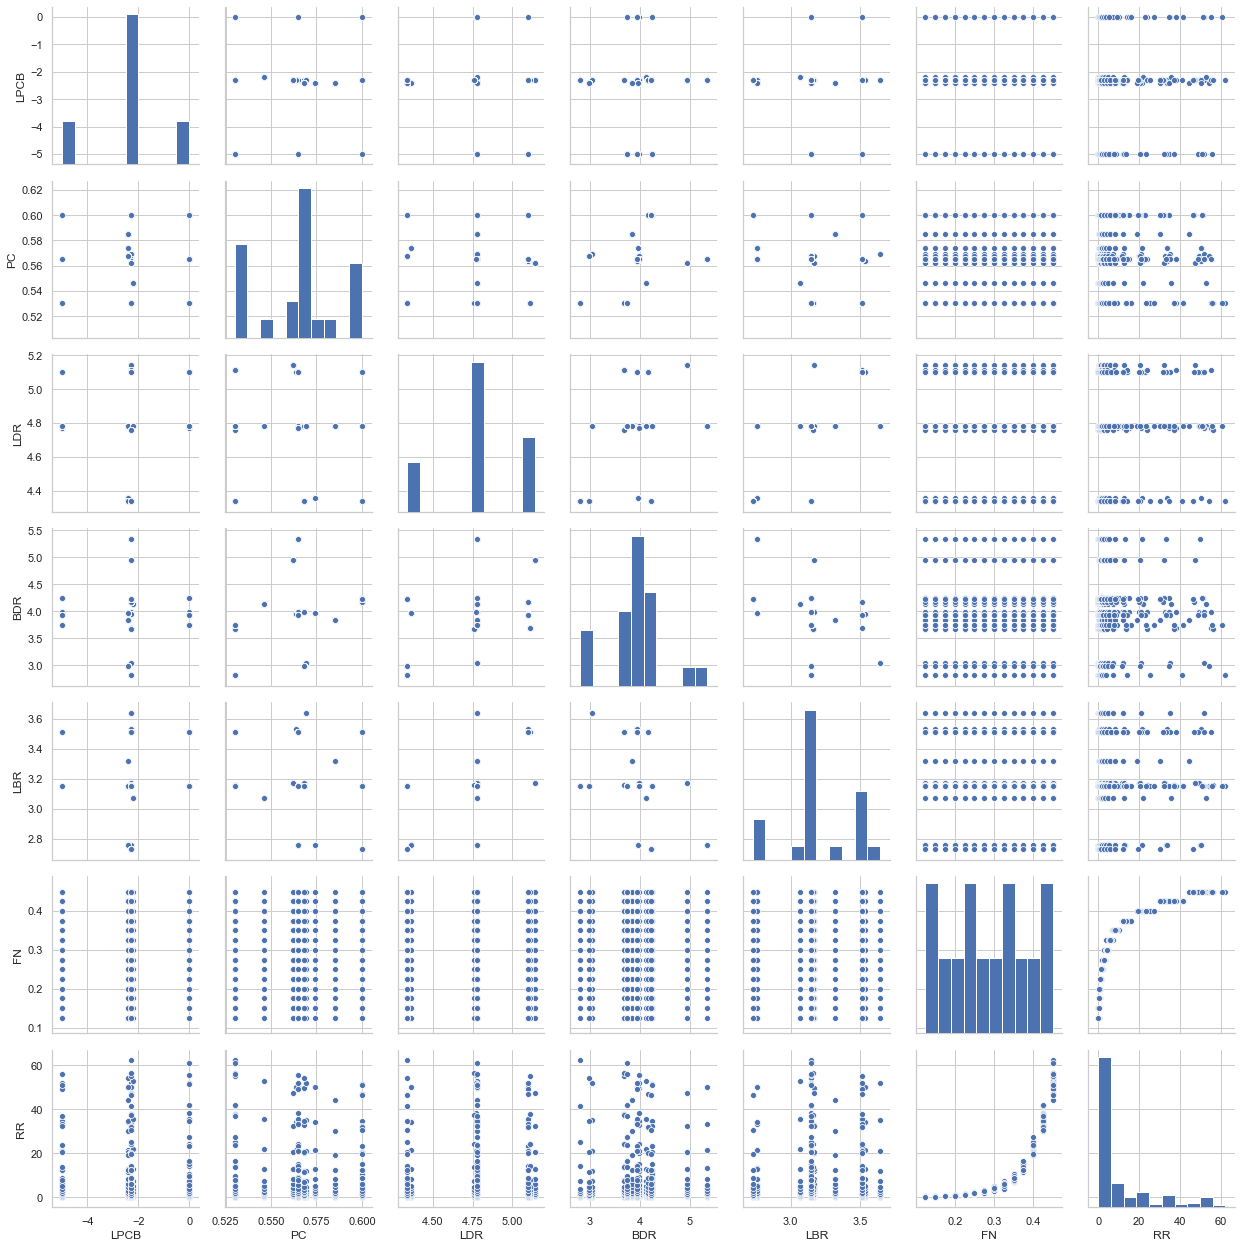

In [36]:
import seaborn as sns

sns.set(style='whitegrid', context='notebook')
cols = ['LPCB', 'PC', 'LDR', 'BDR', 'LBR', 'FN', 'RR']

sns.pairplot(df[cols], height=2.5)
plt.tight_layout()
plt.show()

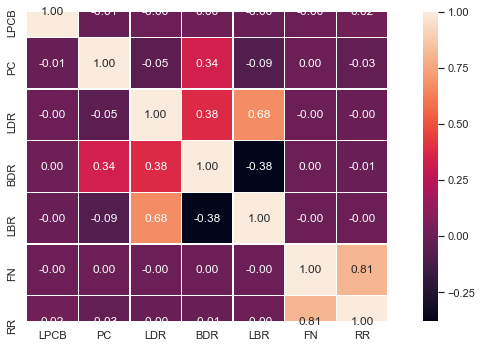

In [37]:
import numpy as np
import seaborn as sns

cols = ['LPCB', 'PC', 'LDR', 'BDR', 'LBR', 'FN', 'RR']
plt.figure(figsize=(10,5))
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm, 
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 12},
            yticklabels=cols,
            xticklabels=cols,
            linewidths=.5)

plt.tight_layout()
plt.show()

## Линейный регрессор

#### Разделение данных на тренировочный и тестовый наборы (70:30)

In [38]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['RR'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [39]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

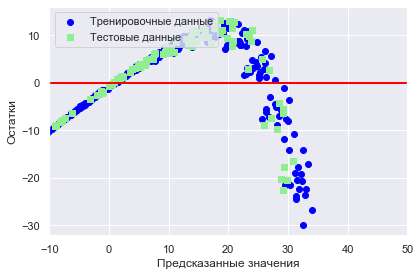

In [40]:
plt.scatter(y_train_pred,  y_train_pred - y_train, c='blue', marker='o', label='Тренировочные данные')
plt.scatter(y_test_pred,  y_test_pred - y_test, c='lightgreen', marker='s', label='Тестовые данные')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

plt.show()

In [41]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print('MSE тренировочное: %.3f, тестирование: %.3f' % (  # mean squared error/средневзвешенная квадратичная ошибка
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 тренировочное: %.3f, тестирование: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE тренировочное: 81.217, тестирование: 77.474
R^2 тренировочное: 0.678, тестирование: 0.549


#### Применение регуляризованных методов для регрессии

In [42]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[  0.50633511  -0.          -0.          -0.37039851  -2.07784231
 115.28162861]


In [43]:
print('MSE тренировка: %.3f, тестирование: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 тренировка: %.3f, тестирование: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE тренировка: 82.806, тестирование: 73.244
R^2 тренировка: 0.672, тестирование: 0.573


## Полиномиальный регрессор

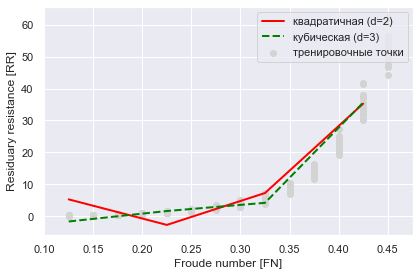

Квадратичная:
MSE тренировка: 19.049, тестирование: 12.891
R^2 тренировка: 0.924, тестирование: 0.925

Кубическая:
MSE тренировка: 4.452, тестирование: 2.443
R^2 тренировка: 0.982, тестирование: 0.986


In [44]:
from sklearn.preprocessing import PolynomialFeatures

X = df[['FN']].values
y = df['RR'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

# создать квадратичные признаки
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)

X_quad_train = quadratic.fit_transform(X_train)
X_quad_test = quadratic.fit_transform(X_test)
X_cubic_train = cubic.fit_transform(X_train)
X_cubic_test = cubic.fit_transform(X_test)

# выполнить подгонку признаков
X_fit = np.arange(X.min(), X.max(), 0.1)[:, np.newaxis]

regr = LinearRegression()

#regr = regr.fit(X, y)
#y_lin_fit = regr.predict(X_fit)
#linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad_train, y_train)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2_train = r2_score(y_train, regr.predict(X_quad_train))
quadratic_r2_test = r2_score(y_test, regr.predict(X_quad_test))
quadratic_mse_train = mean_squared_error(y_train, regr.predict(X_quad_train))
quadratic_mse_test = mean_squared_error(y_test, regr.predict(X_quad_test))

regr = regr.fit(X_cubic_train, y_train)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2_train = r2_score(y_train, regr.predict(X_cubic_train))
cubic_r2_test = r2_score(y_test, regr.predict(X_cubic_test))
cubic_mse_train = mean_squared_error(y_train, regr.predict(X_cubic_train))
cubic_mse_test = mean_squared_error(y_test, regr.predict(X_cubic_test))



# показать результаты на графике
plt.scatter(X, y, label='тренировочные точки', color='lightgray')

#plt.plot(X_fit, y_lin_fit, 
         #label='линейная (d=1), $R^2=%.2f$' % linear_r2, 
         #color='blue', 
         #lw=2, 
         #linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='квадратичная (d=2)',
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='кубическая (d=3)',
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('Froude number [FN]')
plt.ylabel('Residuary resistance [RR]')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

print('Квадратичная:')
print('MSE тренировка: %.3f, тестирование: %.3f' % (
        quadratic_mse_train,
        quadratic_mse_test))

print('R^2 тренировка: %.3f, тестирование: %.3f' % (
        quadratic_r2_train,
        quadratic_r2_test))

print('\nКубическая:')
print('MSE тренировка: %.3f, тестирование: %.3f' % (
        cubic_mse_train,
        cubic_mse_test))

print('R^2 тренировка: %.3f, тестирование: %.3f' % (
        cubic_r2_train,
        cubic_r2_test))


## Регрессия на основе случайного леса

In [45]:
X = df.iloc[:, :-1].values
y = df['RR'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

In [46]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE тренировка: %.3f, тестирование: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 тренировка: %.3f, тестирование: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE тренировка: 0.138, тестирование: 1.805
R^2 тренировка: 0.999, тестирование: 0.991


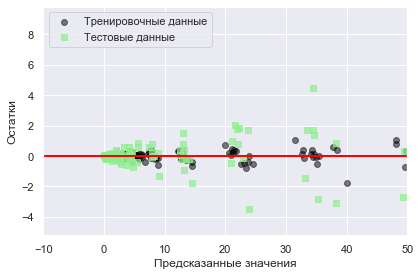

In [47]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='black', 
            marker='o', 
            s=35,
            alpha=0.5,
            label='Тренировочные данные')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='lightgreen', 
            marker='s', 
            s=35,
            alpha=0.7,
            label='Тестовые данные')

plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

plt.show()